# Анализ результатов АБ-теста

In [1]:
import numpy as np
import pandas as pd

В данном задании вам нужно будет проанализировать АБ тест, проведенный на реальных пользователях Яндекса
подтвердить или опровергнуть наличие изменений в пользовательском поведении между контрольной (control) и тестовой (exp) группами
определить характер этих изменений и практическую значимость вводимого изменения
понять, какая из пользовательских групп более всего проигрывает / выигрывает от тестируемого изменения (локализовать изменение)
Описание данных:

- userID: уникальный идентификатор пользователя

- browser: браузер, который использовал userID

- slot: в каком статусе пользователь участвовал в исследовании (exp = видел измененную страницу, control = видел неизменную страницу)

- n_clicks: количество кликов, которые пользоваль совершил за n_queries

- n_queries: количество запросов, который совершил userID, пользуясь браузером browser

- n_nonclk_queries: количество запросов пользователя, в которых им не было совершено ни одного клика

Обращаем ваше внимание, что не все люди используют только один браузер, поэтому в столбце userID есть повторяющиеся идентификаторы. В предлагаемых данных уникальным является сочетание userID и browser.

Основная метрика, на которой мы сосредоточимся в этой работе, — это количество пользовательских кликов на web-странице в зависимости от тестируемого изменения этой страницы.

Посчитайте, насколько в группе exp больше пользовательских кликов по сравнению с группой control в процентах от числа кликов в контрольной группе.

Полученный процент округлите до третьего знака после точки.

In [2]:
df = pd.read_csv("ab_browser_test.csv")
df.head()

,userID,browser,slot,n_clicks,n_queries,n_nonclk_queries
0,1,Browser #2,exp,23,32,19
1,3,Browser #4,exp,3,4,2
2,5,Browser #4,exp,29,35,16
3,6,Browser #4,control,12,6,0
4,7,Browser #4,exp,54,68,30


In [3]:
click_exp = df[df.slot == 'exp'].n_clicks.sum()
click_control = df[df.slot == 'control'].n_clicks.sum()
round((click_exp/click_control - 1)*100, 3)

1.614

Давайте попробуем посмотреть более внимательно на разницу между двумя группами (control и exp) относительно количества пользовательских кликов.

Для этого постройте с помощью бутстрепа 95% доверительный интервал для средних значений и медиан количества кликов в каждой из двух групп. Отметьте все верные утверждения.

In [13]:
def get_bootstrap_samples_median(data, n_samples):
    res = []
    for i in range(n_samples):
        indices = np.random.randint(0, len(data), len(data))
        res.append(np.median(data[indices]))
    print("we win!")
    return np.array(res)

def get_bootstrap_samples_mean(data, n_samples):
    res = []
    for i in range(n_samples):
        indices = np.random.randint(0, len(data), len(data))
        res.append(np.mean(data[indices]))
    print("we win!")
    return np.array(res)
    
def stat_intervals(stat, alpha):
    boundaries = np.percentile(stat, [100 * alpha / 2., 100 * (1 - alpha / 2.)])
    return boundaries

In [26]:
df_exp = df[df.slot == 'exp'].n_clicks
df_control = df[df.slot == 'control'].n_clicks

In [15]:
np.random.seed(0)

control_exp_median_scores = get_bootstrap_samples_median(df_control.values, 500) \
                            - get_bootstrap_samples_median(df_exp.values, 500)
control_exp_mean_scores = get_bootstrap_samples_mean(df_control.values, 500) \
                            - get_bootstrap_samples_mean(df_exp.values, 500)

print("95% confidence interval for the CONTROL median - EXP median repair time:",  stat_intervals(control_exp_median_scores, 0.05))
print("95% confidence interval for the CONTROL mean - EXP mean repair time:",  stat_intervals(control_exp_mean_scores, 0.05))

we win!
we win!
we win!
we win!
95% confidence interval for the CONTROL median - EXP median repair time: [-1. -1.]
95% confidence interval for the CONTROL mean - EXP mean repair time: [-0.40543913 -0.19852156]


t-критерий Стьюдента имеет множество достоинств, и потому его достаточно часто применяют в AB экспериментах. Иногда его применение может быть необоснованно из-за сильной скошенности распределения данных.

Давайте постараемся понять, когда t-критерий можно применять и как это проверить на реальных данных.

Для простоты рассмотрим одновыборочный t-критерий. Его статистика имеет вид $$\frac{\bar{X} - \mu}{ \sqrt {S^2 / n}} $$ то есть чтобы действительно предположения t-критерия выполнялись необходимо, чтобы:

$\bar{X}$— среднее значение в выборке — было распределено нормально N(μ,σ^2/n)

$\frac{n}{σ^2}S^2$ — несмещенная оценка дисперсии c масштабирующим коэффициентом — была распределена по хи-квадрат c n−1 степенями свободы $χ^2(n−1)$

Простое доказательство необходимости и достаточности этого требования можно посмотреть в самом последнем абзаце этого вопроса. Усвоение этого доказательства не обязательно для выполнения задания.

Оба этих предположения можно проверить с помощью бутстрепа. Ограничимся сейчас только контрольной группой, в которой распределение кликов будем называть данными в рамках данного вопроса.

Поскольку мы не знаем истинного распределения генеральной совокупности, мы можем применить бутстреп, чтобы понять, как распределены среднее значение и выборочная дисперсия. Для этого

- Получите из данных n_boot_samples псевдовыборок.
- По каждой из этих выборок посчитайте среднее и сумму квадратов отклонения от выборочного среднего (control_boot_chi_squared)
- Для получившегося вектора средних значений из n_boot_samples постройте q-q plot с помощью scipy.stats.probplot для нормального распределения
- Для получившегося вектора сумм квадратов отклонения от выборочного среднего постройте qq-plot с помощью scipy.stats.probplot для хи-квадрат распределения

In [16]:
def get_bootstrap_mean_and_var(data, n_samples):
    mean = []
    nvar = []
    for i in range(n_samples):
        indices = np.random.randint(0, len(data), len(data))
        m = np.mean(data[indices])
        mean.append(m)
        nvar.append(np.sum((data[indices] - m)**2))
    print("we win!")
    return (np.array(mean), np.array(nvar))

In [17]:
np.random.seed(0)
control_mean, control_boot_chi_squared = get_bootstrap_mean_and_var(df_control.values, 500)

we win!


<function matplotlib.pyplot.show(*args, **kw)>

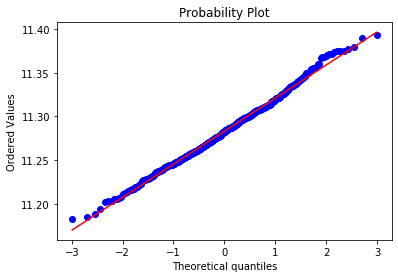

In [19]:
from matplotlib import pylab as plt
from scipy.stats import probplot

res = probplot(control_mean, dist="norm", plot=plt)
plt.show

In [22]:
print("For mean R^2 =", res[1][2]**2)

For mean R^2 = 0.9959537742082044


<function matplotlib.pyplot.show(*args, **kw)>

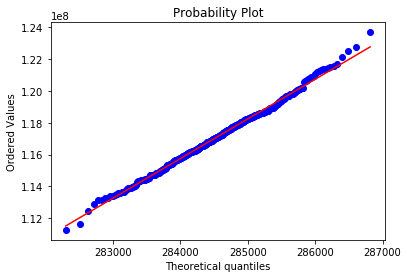

In [24]:
n = len(df_control)
res2 = probplot(control_boot_chi_squared, dist="chi2", sparams=(n-1), plot=plt)
plt.show

In [25]:
print("For n*variance R^2 =", res2[1][2]**2)

For n*variance R^2 = 0.9965174165449134


   Одним из возможных аналогов t-критерия, которым можно воспрользоваться, является тест Манна-Уитни. На достаточно обширном классе распределений он является асимптотически более эффективным, чем t-критерий, и при этом не требует параметрических предположений о характере распределения.

   Разделите выборку на две части, соответствующие control и exp группам. Преобразуйте данные к виду, чтобы каждому пользователю соответствовало суммарное значение его кликов. С помощью критерия Манна-Уитни проверьте гипотезу о равенстве средних.

In [29]:
df_control = df[df.slot == 'control'].groupby(by = 'userID')['n_clicks'].sum()
df_exp = df[df.slot == 'exp'].groupby(by = 'userID')['n_clicks'].sum()

In [32]:
from scipy.stats import mannwhitneyu

mannwhitneyu(df_control, df_exp)
# как мы видим, гипотеза о равенстве средних отвергается

MannwhitneyuResult(statistic=38901259929.0, pvalue=4.3471471887604393e-75)

Проверьте, для какого из браузеров наиболее сильно выражено отличие между количеством кликов в контрольной и экспериментальной группах.

Для этого примените для каждого из срезов (по каждому из уникальных значений столбца browser) критерий Манна-Уитни между control и exp группами и сделайте поправку Холма-Бонферрони на множественную проверку с α=0.05.

Какое заключение можно сделать исходя из полученных результатов ?

В качестве ответа введите количество незначимых изменений с точки зрения результатов, полученных после введения коррекции.

In [41]:
p = []
browsers = list(set(df.browser.values))
l = len(browsers)
for b in browsers:
    df_control = df[(df.slot == 'control') & (df.browser == b)]['n_clicks']
    df_exp = df[(df.slot == 'exp') & (df.browser == b)]['n_clicks']
    p.append(mannwhitneyu(df_control, df_exp)[1])
for i in range(l):
    print('p для', browsers[i],'=', p[i])
# отклоняем 3 гипотезы о равенстве средних

p для Browser #2 = 0.0272438604197241
p для Browser #14 = 0.0
p для Browser #20 = 0.45366656388735377
p для Browser #4 = 0.40760617658454984
p для Browser #17 = 0.03740060143010802
p для Browser #22 = 0.2574055152210032


In [45]:
from statsmodels.sandbox.stats.multicomp import multipletests

p_corrected = multipletests(p, alpha = 0.05, method = "holm")[1]
for i in range(l):
    print('p_corrected для', browsers[i],'=', p_corrected[i])
# теперь отклоняем только 1

p_corrected для Browser #2 = 0.13621930209862051
p_corrected для Browser #14 = 0.0
p_corrected для Browser #20 = 0.8152123531690997
p_corrected для Browser #4 = 0.8152123531690997
p_corrected для Browser #17 = 0.14960240572043207
p_corrected для Browser #22 = 0.7722165456630096


Для каждого браузера в каждой из двух групп (control и exp) посчитайте долю запросов, в которых пользователь не кликнул ни разу. Это можно сделать, поделив сумму значений n_nonclk_queries на сумму значений n_queries. Умножив это значение на 100, получим процент некликнутых запросов, который можно легче проинтерпретировать.

Сходятся ли результаты проведенного Вами анализа с показателем процента некликнутых запросов ? Отметьте все верные утверждения.

In [47]:
for b in browsers:
    df_control = df[(df.slot == 'control') & (df.browser == b)]
    df_exp = df[(df.slot == 'exp') & (df.browser == b)]
    print("Некликнутые запросы в control для", b, "= ", df_control.n_nonclk_queries.sum()/df_control.n_queries.sum()*100, 
            "% ; в exp = ", df_exp.n_nonclk_queries.sum()/df_exp.n_queries.sum()*100, "%")
# на контроле некликнутых больше для браузеров кроме 17го

Некликнутые запросы в control для Browser #2 =  45.96274717919465 % ; в exp =  44.982746948554706 %
Некликнутые запросы в control для Browser #14 =  57.59041136008114 % ; в exp =  43.755617361273295 %
Некликнутые запросы в control для Browser #20 =  40.540484743383296 % ; в exp =  38.97737648371716 %
Некликнутые запросы в control для Browser #4 =  46.97092963514274 % ; в exp =  45.14294190358467 %
Некликнутые запросы в control для Browser #17 =  36.29936674628208 % ; в exp =  36.93741284866483 %
Некликнутые запросы в control для Browser #22 =  40.593976593513354 % ; в exp =  39.85394721969546 %
